In [2]:
import json
import random
from collections import Counter

from tqdm import tqdm
import nltk
import matplotlib.pyplot as plt#约定俗成的写法plt

sen_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

### Extract Yes/No questions from MS MARCO

For each query, select a passage which is marked as `is_selected=1` and randomly some passages which are not marked like that to obtain a new passage which has more sentences.

Final dataset process parameters:
- drop_yes=True
- prob=0.4
- neg_instances_num=2
- min_sen_num=6
- chunk_sen_num=8

In [3]:
from pytorch_pretrained_bert.tokenization import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('../CoQA-Challenge/BERT/bert-base-uncased-vocab.txt')

In [4]:
def judge_yes_no(answer_list):
    if len(answer_list) == 0:
        return None
    
    yesno_cnt = Counter(answer_list)
    
    most = yesno_cnt.most_common(1)[0][0]
    assert most in ['yes', 'no']
    
    if len(yesno_cnt) == 1:
        return most
    else:
        if yesno_cnt['yes'] == yesno_cnt['no']:
            return None
        else:
            return most

In [5]:
def find_yes_no(answer_text):
    if answer_text in ['No Answer Present.', '']:
        return None
    
    import string
    delset = string.punctuation
    
    token = answer_text.split()[0].strip()
    if token[-1] in delset:
        token = token.replace(token[-1], '')
    token = token.lower()
    if token in ['yes', 'no']:
        return token
    else:
        return None
    

In [6]:
def assert_unique_id(id_list):
    id_cnt = Counter(id_list)
    assert id_cnt.most_common(1)[0][1] == 1

In [7]:
def draw(counter):
    sorted_cnt = sorted(counter.items(), key=lambda x: x[0], reverse=False)
    x = list(map(lambda k: k[0], sorted_cnt))
    y = list(map(lambda k: k[1], sorted_cnt))
    plt.plot(x, y)
    plt.show()

In [8]:
def randomly_choose(select_id, unselect_list, neg_num):
    unselect_list = unselect_list[:neg_num]
    random.shuffle(unselect_list)
    combined_list = [select_id] + unselect_list
    random.shuffle(combined_list)
    return combined_list

In [9]:
def extract_yesno_combine(file, drop_yes: bool=False, prob: float=0, chunk_sen_num: int = 5, 
                          min_sen_num: int = 4, max_sen_num: int = 50, neg_instances_num: int = 3):
    
    print(f'drop yes: {drop_yes}')
    print(f'drop probility: {prob}')
    with open(file, 'r') as f:
        data = json.load(f)
    answers = list(data['answers'].values())
    passages = list(data['passages'].values())
    query = list(data['query'].values())
    query_id = list(data['query_id'].values())

    length_cnt = Counter()
    sen_num = Counter()
    word_piece_cnt = Counter()
    
    yesnos = []
    para = []
    ques = []
    q_id = []
    long_article = 0
    for idx, ans_list in enumerate(tqdm(answers)):
        yesno_list = []
        for ans in ans_list:
            res = find_yes_no(ans)
            if res is not None:
                yesno_list.append(res)
        
        yesno = judge_yes_no(yesno_list)
        if yesno is None:
            continue
        
        # Maintain two list for index of selected passages and non-selected passages
        selected_pid = []
        unselected_pid = []
        for p_id, p in enumerate(passages[idx]):
            if p['is_selected'] == 1:
                selected_pid.append(p_id)
            else:
                unselected_pid.append(p_id)
        for s_pid in selected_pid:
            p_text = passages[idx][s_pid]['passage_text']
            sentence_num = len(sen_tokenizer.tokenize(p_text))
            if sentence_num >= chunk_sen_num:
                article = [{'is_selected': 1, 'text': p_text}]
                pass_len = len(p_text.split())
                word_piece_num = len(tokenizer.tokenize(p_text))
            else:
                if len(unselected_pid) == 0:
                    continue
                # If the sentence num is small than `min_sen_num`, the negative instances num would be added with one.
                if sentence_num <= min_sen_num:
                    cur_neg_num = neg_instances_num + 1
                else:
                    cur_neg_num = neg_instances_num
                shuffle_id_list = randomly_choose(s_pid, unselected_pid, cur_neg_num)
                
                article = [{'is_selected': 1 if sh_id == s_pid else 0, 
                            'text': passages[idx][sh_id]['passage_text']} for sh_id in shuffle_id_list]

                sentence_num = 0
                pass_len = 0
                word_piece_num = 0
                for p in article:
                    sentence_num += len(sen_tokenizer.tokenize(p['text']))
                    pass_len += len(p['text'].split())
                    word_piece_num += len(tokenizer.tokenize(p['text']))
                    

            if word_piece_num > 450:
                continue
            if sentence_num > max_sen_num:
                long_article += 1
                continue
            # Randomly drop yes
            if drop_yes and yesno == 'yes':
                r = random.random()
                if r < prob:
                    continue
    
            para.append(article)
            length_cnt[pass_len] += 1
            sen_num[sentence_num] += 1
            word_piece_cnt[word_piece_num] += 1
                
            yesnos.append(yesno)
            ques.append(query[idx])
            q_id.append(str(query_id[idx]) + '--' + str(s_pid))
    
    draw(sen_num)
    draw(length_cnt)
    draw(word_piece_cnt)
    
    print(f'Total number of dataset is {len(ques)}')
    
    yes_num = 0
    for t in yesnos:
        if t == 'yes':
            yes_num += 1
    print(f'Yes ratio: {yes_num * 1.0 / len(yesnos)}')
    
    assert len(para) == len(q_id) == len(ques) == len(yesnos), f'{len(para)}, {len(q_id)}, {len(ques)}, {len(yesnos)}'
    
    assert_unique_id(q_id)
    
    print(f'long article number: {long_article}')
    
    return {
        'passages': para,
        'ids': q_id,
        'questions': ques,
        'yes_no': yesnos
    }

drop yes: True
drop probility: 0.45


100%|██████████| 101093/101093 [00:19<00:00, 5258.13it/s]


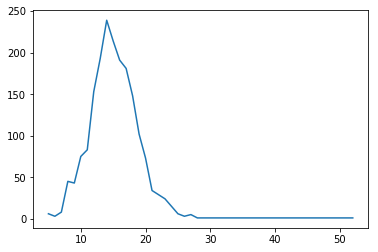

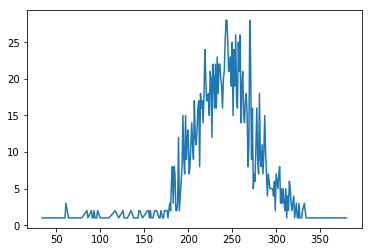

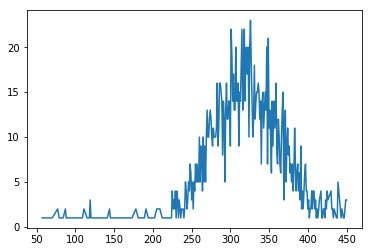

Total number of dataset is 1875
Yes ratio: 0.7146666666666667
long article number: 0


In [90]:
dev = extract_yesno_combine('dev_v2.1.json', drop_yes=True, prob=0.45, neg_instances_num=3, 
                            min_sen_num=4, max_sen_num=80, chunk_sen_num=8)
with open('dev-yesno-cb.json', 'w') as f:
    json.dump(dev, f, indent=2)

drop yes: True
drop probility: 0.45


100%|██████████| 808731/808731 [03:37<00:00, 3718.59it/s] 


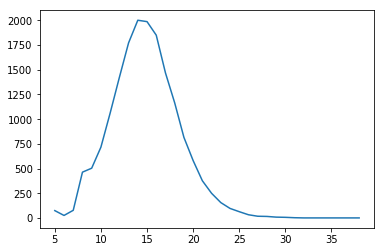

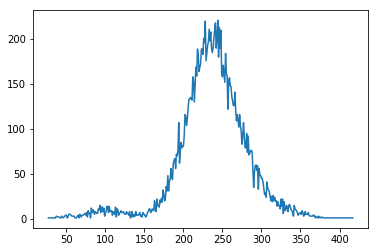

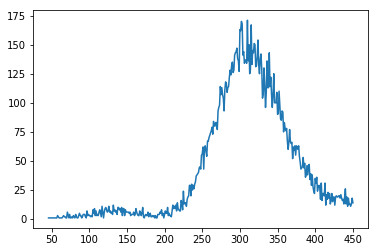

Total number of dataset is 17022
Yes ratio: 0.6740101045705558
long article number: 0


In [91]:
train = extract_yesno_combine('train_v2.1.json', drop_yes=True, prob=0.45, neg_instances_num=3,
                              min_sen_num=4, max_sen_num=80, chunk_sen_num=8)
with open('train-yesno-cb.json', 'w') as f:
    json.dump(train, f, indent=2)

drop yes: True
drop probility: 0.7


100%|██████████| 101093/101093 [00:23<00:00, 4233.99it/s]


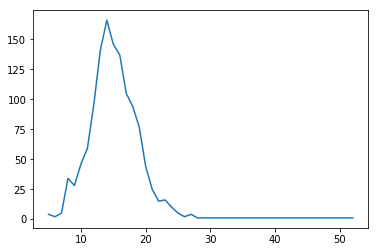

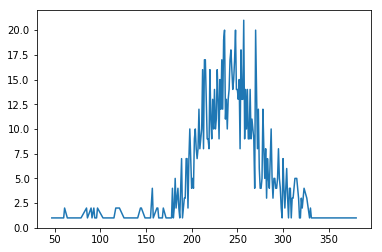

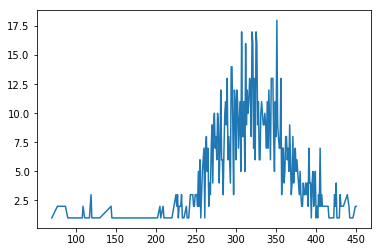

Total number of dataset is 1265
Yes ratio: 0.5770750988142292
long article number: 0


In [11]:
dev = extract_yesno_combine('dev_v2.1.json', drop_yes=True, prob=0.70, neg_instances_num=3, 
                            min_sen_num=4, max_sen_num=80, chunk_sen_num=8)
with open('dev-yesno-cb-dp70.json', 'w') as f:
    json.dump(dev, f, indent=2)

drop yes: True
drop probility: 0.7


100%|██████████| 808731/808731 [04:23<00:00, 3069.43it/s]


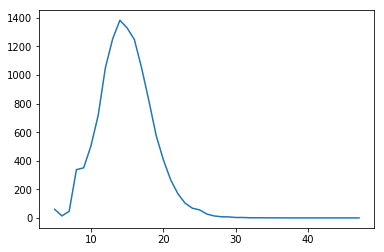

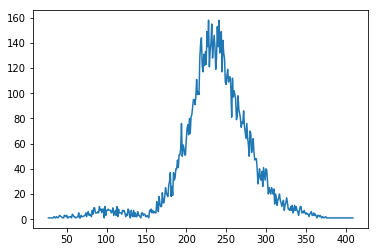

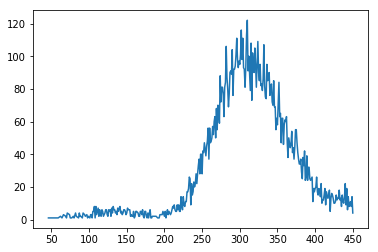

Total number of dataset is 11884
Yes ratio: 0.5330696735106025
long article number: 0


In [12]:
train = extract_yesno_combine('train_v2.1.json', drop_yes=True, prob=0.70, neg_instances_num=3,
                              min_sen_num=4, max_sen_num=80, chunk_sen_num=8)
with open('train-yesno-cb-dp70.json', 'w') as f:
    json.dump(train, f, indent=2)

In [40]:
with open('../CoQA-Challenge/BERT/max_f1/coqa-train-v1.0.json', 'r') as f:
    data = json.load(f)['data']

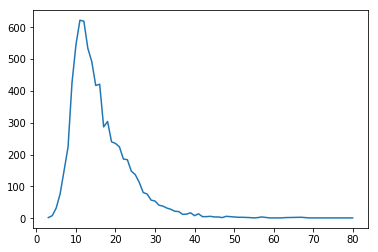

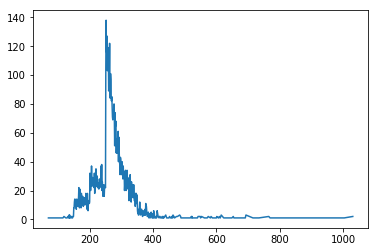

In [41]:
coqa_sen_cnt = Counter()
coqa_pass_cnt = Counter()

for article in data:
    story = article['story']
    coqa_sen_cnt[len(sen_tokenizer.tokenize(story))] += 1
    coqa_pass_cnt[len(story.split())] += 1

draw(coqa_sen_cnt)
draw(coqa_pass_cnt)